In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image
from torch.utils.data.dataset import Dataset
from PIL import Image
import random
from torch.utils.data.sampler import SequentialSampler

os.environ["CUDA_VISIBLE_DEVICES"]='3,4'


## Training

In [2]:
class AvenueDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root=root
        self.transforms=transforms
        self.videonames=(os.listdir(self.root))
        self.videonames.sort()
        
    def __getitem__(self, index):
        transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])
        if index % 66 == 0:
            self.randperm=torch.randperm(66)
        video_name=self.videonames[self.randperm[index % 66]]
        video_dir=os.path.join(self.root, video_name)
        num_frame=len(os.listdir(video_dir))
        start_index=random.randint(0, num_frame-10)
        image_list = os.listdir(video_dir)
        image_list.sort()
        input_tensor = [torch.squeeze(transform(Image.open(os.path.join(video_dir, image_list[i])))) for i in range(start_index, start_index+10)]
        #image_path=os.path.join(video_dir, 'image-%05d.jpg')
        #input_tensor = [torch.squeeze(transform(Image.open(image_path % i))) for i in range(start_index, start_index+10)]
        input_tensor = torch.stack(input_tensor)
        return input_tensor, video_name
            
        
    def __len__(self): # 가능한 모든 tensor(10x227x227)의 수
        return sum([len(os.listdir(os.path.join(self.root, subdir))) for subdir in os.listdir(self.root)]) - 9*len(os.listdir(self.root))

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
checkpoint_dir = 'checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)
num_epochs = 5
batch_size = 32
learning_rate = 0.001

traindir = 'data'

train_dataset = AvenueDataset(traindir)

sampler=SequentialSampler(train_dataset)

data_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=False, sampler=sampler)


In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15,6))

for _, (d, l) in enumerate(data_loader):
    for i in range(10):
        a=fig.add_subplot(2,5,i+1)
        a.set_title('frame %d'%(i+1))
        plt.imshow(d[0][i])
    break
plt.show()

<Figure size 1500x600 with 10 Axes>

In [5]:



class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.cv1 = nn.Conv2d(10,512,11,4)
        self.pl1 = nn.MaxPool2d(2,return_indices=True)
        self.cv2 = nn.Conv2d(512,256,5, padding=2)
        self.pl2 = nn.MaxPool2d(2,return_indices=True)
        self.cv3 = nn.Conv2d(256,128,3, padding=1)
        self.dc1 = nn.ConvTranspose2d(128,256,3,padding=1)
        self.up1 = nn.MaxUnpool2d(2)
        self.dc2 = nn.ConvTranspose2d(256,512,3,padding=1)
        self.up2 = nn.MaxUnpool2d(2)
        self.dc3 = nn.ConvTranspose2d(512,1024,5,padding=2)
        self.dc4 = nn.ConvTranspose2d(1024,10,11,4)
        
        torch.nn.init.xavier_uniform_(self.cv1.weight)
        torch.nn.init.xavier_uniform_(self.cv2.weight)
        torch.nn.init.xavier_uniform_(self.cv3.weight)
        torch.nn.init.xavier_uniform_(self.dc1.weight)
        torch.nn.init.xavier_uniform_(self.dc2.weight)
        torch.nn.init.xavier_uniform_(self.dc3.weight)
        torch.nn.init.xavier_uniform_(self.dc4.weight)
        
        
    def encode(self, x):
        x = F.relu(self.cv1(x))
        self.size1=x.size()
        x, self.idx1 = self.pl1(x)
        x = F.relu(self.cv2(x))
        self.size2=x.size()
        x, self.idx2 = self.pl1(x)
        x = F.relu(self.cv3(x))
        return x
    
    def decode(self, x):
        x = F.relu(self.dc1(x))
        x = self.up1(x,self.idx2,output_size=self.size2)
        x = F.relu(self.dc2(x))
        x = self.up2(x,self.idx1,output_size=self.size1)
        x = F.relu(self.dc3(x))
        x = torch.tanh(self.dc4(x))
        return x
    
    def forward(self, x):
        out = self.encode(x)
        out = self.decode(out)
        return out
    

In [6]:

model = CAE().to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
criteria = nn.MSELoss()


In [7]:


for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        x = x.to(device)
        x_reconst = model(x)
        
        reconst_loss = criteria(x_reconst, x)
    
        optimizer.zero_grad()
        reconst_loss.backward()
        optimizer.step()
        
        if(i+1)%10==0:
            print("Epoch[{}/{}], Step[{}/{}], Reconst Loss: {:.4f}"
                  .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()))
    with torch.no_grad():
        # Save the sampled images
        denorm = x[0]*0.5+0.5
        denorm_reconst = x_reconst[0]*0.5+0.5
        save_image(denorm.view(-1,1,227,227),os.path.join(sample_dir, 'sampled-{:03d}.png'.format(epoch+1)))
        
        # Save the reconstructed images
        x_concat = torch.cat([denorm.view(-1,1,227,227),denorm_reconst.view(-1,1,227,227)], dim = 3)
        save_image(x_concat, os.path.join(sample_dir, 'reconst-{:03d}.png'.format(epoch+1)))
        
        # Save the model parameters
        torch.save(model.state_dict(), (os.path.join(checkpoint_dir, 'checkpoint-{:03d}.pth'.format(epoch+1))))

Epoch[1/5], Step[10/753], Reconst Loss: 0.2106
Epoch[1/5], Step[20/753], Reconst Loss: 0.1016
Epoch[1/5], Step[30/753], Reconst Loss: 0.0510
Epoch[1/5], Step[40/753], Reconst Loss: 0.0398
Epoch[1/5], Step[50/753], Reconst Loss: 0.0443
Epoch[1/5], Step[60/753], Reconst Loss: 0.0297
Epoch[1/5], Step[70/753], Reconst Loss: 0.0257
Epoch[1/5], Step[80/753], Reconst Loss: 0.0249
Epoch[1/5], Step[90/753], Reconst Loss: 0.0219
Epoch[1/5], Step[100/753], Reconst Loss: 0.0175
Epoch[1/5], Step[110/753], Reconst Loss: 0.0178
Epoch[1/5], Step[120/753], Reconst Loss: 0.0146
Epoch[1/5], Step[130/753], Reconst Loss: 0.0140
Epoch[1/5], Step[140/753], Reconst Loss: 0.0129
Epoch[1/5], Step[150/753], Reconst Loss: 0.0129
Epoch[1/5], Step[160/753], Reconst Loss: 0.0117
Epoch[1/5], Step[170/753], Reconst Loss: 0.0104
Epoch[1/5], Step[180/753], Reconst Loss: 0.0110
Epoch[1/5], Step[190/753], Reconst Loss: 0.0124
Epoch[1/5], Step[200/753], Reconst Loss: 0.0130
Epoch[1/5], Step[210/753], Reconst Loss: 0.0092
E

Epoch[3/5], Step[230/753], Reconst Loss: 0.0041
Epoch[3/5], Step[240/753], Reconst Loss: 0.0036
Epoch[3/5], Step[250/753], Reconst Loss: 0.0041
Epoch[3/5], Step[260/753], Reconst Loss: 0.0039
Epoch[3/5], Step[270/753], Reconst Loss: 0.0037
Epoch[3/5], Step[280/753], Reconst Loss: 0.0032
Epoch[3/5], Step[290/753], Reconst Loss: 0.0045
Epoch[3/5], Step[300/753], Reconst Loss: 0.0039
Epoch[3/5], Step[310/753], Reconst Loss: 0.0040
Epoch[3/5], Step[320/753], Reconst Loss: 0.0036
Epoch[3/5], Step[330/753], Reconst Loss: 0.0038
Epoch[3/5], Step[340/753], Reconst Loss: 0.0049
Epoch[3/5], Step[350/753], Reconst Loss: 0.0036
Epoch[3/5], Step[360/753], Reconst Loss: 0.0038
Epoch[3/5], Step[370/753], Reconst Loss: 0.0041
Epoch[3/5], Step[380/753], Reconst Loss: 0.0037
Epoch[3/5], Step[390/753], Reconst Loss: 0.0042
Epoch[3/5], Step[400/753], Reconst Loss: 0.0033
Epoch[3/5], Step[410/753], Reconst Loss: 0.0039
Epoch[3/5], Step[420/753], Reconst Loss: 0.0036
Epoch[3/5], Step[430/753], Reconst Loss:

Epoch[5/5], Step[450/753], Reconst Loss: 0.0036
Epoch[5/5], Step[460/753], Reconst Loss: 0.0030
Epoch[5/5], Step[470/753], Reconst Loss: 0.0030
Epoch[5/5], Step[480/753], Reconst Loss: 0.0031
Epoch[5/5], Step[490/753], Reconst Loss: 0.0032
Epoch[5/5], Step[500/753], Reconst Loss: 0.0037
Epoch[5/5], Step[510/753], Reconst Loss: 0.0030
Epoch[5/5], Step[520/753], Reconst Loss: 0.0030
Epoch[5/5], Step[530/753], Reconst Loss: 0.0027
Epoch[5/5], Step[540/753], Reconst Loss: 0.0028
Epoch[5/5], Step[550/753], Reconst Loss: 0.0033
Epoch[5/5], Step[560/753], Reconst Loss: 0.0034
Epoch[5/5], Step[570/753], Reconst Loss: 0.0029
Epoch[5/5], Step[580/753], Reconst Loss: 0.0031
Epoch[5/5], Step[590/753], Reconst Loss: 0.0031
Epoch[5/5], Step[600/753], Reconst Loss: 0.0033
Epoch[5/5], Step[610/753], Reconst Loss: 0.0033
Epoch[5/5], Step[620/753], Reconst Loss: 0.0032
Epoch[5/5], Step[630/753], Reconst Loss: 0.0033
Epoch[5/5], Step[640/753], Reconst Loss: 0.0032
Epoch[5/5], Step[650/753], Reconst Loss:

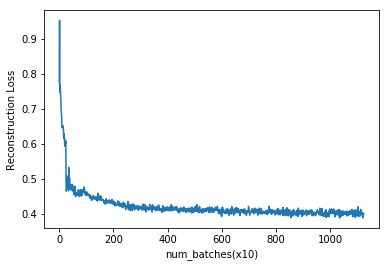

In [31]:
import matplotlib.pyplot as plt

losses = []
with open('loss.txt','r') as f:
    for line in f:
        losses.append(float(line.split(':')[1]))

plt.plot(losses)
plt.ylabel('Reconstruction Loss')
plt.xlabel('num_batches(x10)')
plt.show()


## Testing

In [9]:
from torch.utils.data.dataset import Dataset
import torch
class AvenueTestDataset(Dataset):
    def __init__(self, root, video_index, transforms=None):
        self.root=root
        self.video_index=video_index
        self.videos = os.listdir(self.root)
        self.videos.sort()
    def __getitem__(self, index):
        transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])

        video_dir=os.path.join(self.root, self.videos[self.video_index])
        num_frame=len(os.listdir(video_dir))
        image_list = os.listdir(video_dir)
        image_list.sort()
        input_tensor = [torch.squeeze(transform(Image.open(os.path.join(video_dir, image_list[i])))) for i in range(index, index+10)]
        input_tensor = torch.stack(input_tensor)
        return input_tensor
    
    def __len__(self):
        video_dir=os.path.join(self.root, self.videos[self.video_index])
        return len(os.listdir(video_dir))-9

In [32]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
model.load_state_dict(torch.load('checkpoints/checkpoint-005.pth'))
test_dataset = AvenueTestDataset('test_data/',0)
criteria = nn.MSELoss()


In [33]:
losses = []
for i in range(len(test_dataset)):
    with torch.no_grad():
        x = test_dataset[i]
        x = x.to(device)
        x.unsqueeze_(0)
        x_reconst = model(x)
        loss = criteria(x_reconst,x)
        losses.append(loss.item())
        print('loss: %f' % loss)

loss: 0.004609
loss: 0.004397
loss: 0.004391
loss: 0.004378
loss: 0.004436
loss: 0.004271
loss: 0.004412
loss: 0.004310
loss: 0.004360
loss: 0.004290
loss: 0.004227
loss: 0.004300
loss: 0.004383
loss: 0.004336
loss: 0.004429
loss: 0.004461
loss: 0.004439
loss: 0.004416
loss: 0.004383
loss: 0.004360
loss: 0.004338
loss: 0.004281
loss: 0.004342
loss: 0.004304
loss: 0.004322
loss: 0.004331
loss: 0.004388
loss: 0.004471
loss: 0.004447
loss: 0.004368
loss: 0.004467
loss: 0.004472
loss: 0.004472
loss: 0.004409
loss: 0.004438
loss: 0.004405
loss: 0.004390
loss: 0.004351
loss: 0.004381
loss: 0.004368
loss: 0.004392
loss: 0.004367
loss: 0.004354
loss: 0.004416
loss: 0.004344
loss: 0.004402
loss: 0.004479
loss: 0.004489
loss: 0.004448
loss: 0.004446
loss: 0.004505
loss: 0.004501
loss: 0.004446
loss: 0.004441
loss: 0.004514
loss: 0.004476
loss: 0.004516
loss: 0.004579
loss: 0.004609
loss: 0.004621
loss: 0.004611
loss: 0.004504
loss: 0.004499
loss: 0.004505
loss: 0.004442
loss: 0.004474
loss: 0.00

loss: 0.006442
loss: 0.006433
loss: 0.006310
loss: 0.006299
loss: 0.006326
loss: 0.006286
loss: 0.006131
loss: 0.006028
loss: 0.005880
loss: 0.005950
loss: 0.005884
loss: 0.005878
loss: 0.005827
loss: 0.005893
loss: 0.005896
loss: 0.005906
loss: 0.005961
loss: 0.006025
loss: 0.005953
loss: 0.005979
loss: 0.006075
loss: 0.005997
loss: 0.005941
loss: 0.006004
loss: 0.005803
loss: 0.005772
loss: 0.005827
loss: 0.005868
loss: 0.005968
loss: 0.006015
loss: 0.006013
loss: 0.005979
loss: 0.005893
loss: 0.005781
loss: 0.005889
loss: 0.005866
loss: 0.005846
loss: 0.005744
loss: 0.005854
loss: 0.005834
loss: 0.005846
loss: 0.005747
loss: 0.005746
loss: 0.005794
loss: 0.005885
loss: 0.006033
loss: 0.006044
loss: 0.006152
loss: 0.006252
loss: 0.006449
loss: 0.006428
loss: 0.006353
loss: 0.006366
loss: 0.006382
loss: 0.006426
loss: 0.006524
loss: 0.006608
loss: 0.006603
loss: 0.006605
loss: 0.006535
loss: 0.006442
loss: 0.006273
loss: 0.006212
loss: 0.006120
loss: 0.005965
loss: 0.005861
loss: 0.00

loss: 0.008277
loss: 0.008199
loss: 0.008257
loss: 0.008052
loss: 0.007957
loss: 0.007904
loss: 0.007902
loss: 0.007823
loss: 0.007854
loss: 0.007969
loss: 0.007955
loss: 0.007901
loss: 0.008023
loss: 0.008159
loss: 0.008080
loss: 0.008104
loss: 0.008011
loss: 0.007954
loss: 0.007658
loss: 0.007760
loss: 0.007762
loss: 0.007658
loss: 0.007597
loss: 0.007602
loss: 0.007592
loss: 0.007602
loss: 0.007604
loss: 0.007519
loss: 0.007534
loss: 0.007472
loss: 0.007449
loss: 0.007454
loss: 0.007473
loss: 0.007546
loss: 0.007630
loss: 0.007597
loss: 0.007440
loss: 0.007496
loss: 0.007654
loss: 0.007665
loss: 0.007691
loss: 0.007578
loss: 0.007575
loss: 0.007610
loss: 0.007669
loss: 0.007677
loss: 0.007788
loss: 0.007752
loss: 0.007551
loss: 0.007474
loss: 0.007553
loss: 0.007411
loss: 0.007263
loss: 0.007265
loss: 0.007192
loss: 0.007080
loss: 0.006967
loss: 0.006889
loss: 0.006930
loss: 0.006902
loss: 0.006923
loss: 0.006887
loss: 0.006730
loss: 0.006664
loss: 0.006747
loss: 0.006635
loss: 0.00

In [34]:
max_loss = max(losses)
min_loss = min(losses)
regularity_list = [1 - (loss - min_loss) / max_loss for loss in losses]

## Anomaly Detection

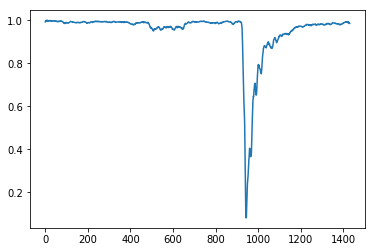

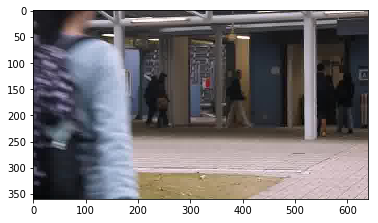

In [35]:
import matplotlib.pyplot as plt
plt.plot(regularity_list)
plt.show()
plt.imshow(Image.open('test_data/Avenue_testing_01/image-00945.jpg'))

In [36]:
regularity_list.index(min(regularity_list))

943

## Preparing files for performance measure

In [37]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
model.load_state_dict(torch.load('checkpoints/checkpoint-005.pth'))
criteria = nn.MSELoss()

In [38]:
for i in range(0,69):
    test_dataset = AvenueTestDataset('test_data/',i)
    with open('testing_regularity_list/'+'%d_reg.txt'%i, 'w') as f:
        losses = []
        for i in range(len(test_dataset)):
            with torch.no_grad():
                x = test_dataset[i]
                x = x.to(device)
                x.unsqueeze_(0)
                x_reconst = model(x)
                loss = criteria(x_reconst,x)
                losses.append(loss.item())
                print('loss: %f' % loss)
        max_loss = max(losses)
        min_loss = min(losses)
        regularity_list = [1 - (loss - min_loss) / max_loss for loss in losses]
        for j in range(len(regularity_list)):
            f.write('%f\n'%regularity_list[j])

loss: 0.004609
loss: 0.004397
loss: 0.004391
loss: 0.004378
loss: 0.004436
loss: 0.004271
loss: 0.004412
loss: 0.004310
loss: 0.004360
loss: 0.004290
loss: 0.004227
loss: 0.004300
loss: 0.004383
loss: 0.004336
loss: 0.004429
loss: 0.004461
loss: 0.004439
loss: 0.004416
loss: 0.004383
loss: 0.004360
loss: 0.004338
loss: 0.004281
loss: 0.004342
loss: 0.004304
loss: 0.004322
loss: 0.004331
loss: 0.004388
loss: 0.004471
loss: 0.004447
loss: 0.004368
loss: 0.004467
loss: 0.004472
loss: 0.004472
loss: 0.004409
loss: 0.004438
loss: 0.004405
loss: 0.004390
loss: 0.004351
loss: 0.004381
loss: 0.004368
loss: 0.004392
loss: 0.004367
loss: 0.004354
loss: 0.004416
loss: 0.004344
loss: 0.004402
loss: 0.004479
loss: 0.004489
loss: 0.004448
loss: 0.004446
loss: 0.004505
loss: 0.004501
loss: 0.004446
loss: 0.004441
loss: 0.004514
loss: 0.004476
loss: 0.004516
loss: 0.004579
loss: 0.004609
loss: 0.004621
loss: 0.004611
loss: 0.004504
loss: 0.004499
loss: 0.004505
loss: 0.004442
loss: 0.004474
loss: 0.00

loss: 0.006310
loss: 0.006299
loss: 0.006326
loss: 0.006286
loss: 0.006131
loss: 0.006028
loss: 0.005880
loss: 0.005950
loss: 0.005884
loss: 0.005878
loss: 0.005827
loss: 0.005893
loss: 0.005896
loss: 0.005906
loss: 0.005961
loss: 0.006025
loss: 0.005953
loss: 0.005979
loss: 0.006075
loss: 0.005997
loss: 0.005941
loss: 0.006004
loss: 0.005803
loss: 0.005772
loss: 0.005827
loss: 0.005868
loss: 0.005968
loss: 0.006015
loss: 0.006013
loss: 0.005979
loss: 0.005893
loss: 0.005781
loss: 0.005889
loss: 0.005866
loss: 0.005846
loss: 0.005744
loss: 0.005854
loss: 0.005834
loss: 0.005846
loss: 0.005747
loss: 0.005746
loss: 0.005794
loss: 0.005885
loss: 0.006033
loss: 0.006044
loss: 0.006152
loss: 0.006252
loss: 0.006449
loss: 0.006428
loss: 0.006353
loss: 0.006366
loss: 0.006382
loss: 0.006426
loss: 0.006524
loss: 0.006608
loss: 0.006603
loss: 0.006605
loss: 0.006535
loss: 0.006442
loss: 0.006273
loss: 0.006212
loss: 0.006120
loss: 0.005965
loss: 0.005861
loss: 0.005828
loss: 0.005812
loss: 0.00

loss: 0.008052
loss: 0.007957
loss: 0.007904
loss: 0.007902
loss: 0.007823
loss: 0.007854
loss: 0.007969
loss: 0.007955
loss: 0.007901
loss: 0.008023
loss: 0.008159
loss: 0.008080
loss: 0.008104
loss: 0.008011
loss: 0.007954
loss: 0.007658
loss: 0.007760
loss: 0.007762
loss: 0.007658
loss: 0.007597
loss: 0.007602
loss: 0.007592
loss: 0.007602
loss: 0.007604
loss: 0.007519
loss: 0.007534
loss: 0.007472
loss: 0.007449
loss: 0.007454
loss: 0.007473
loss: 0.007546
loss: 0.007630
loss: 0.007597
loss: 0.007440
loss: 0.007496
loss: 0.007654
loss: 0.007665
loss: 0.007691
loss: 0.007578
loss: 0.007575
loss: 0.007610
loss: 0.007669
loss: 0.007677
loss: 0.007788
loss: 0.007752
loss: 0.007551
loss: 0.007474
loss: 0.007553
loss: 0.007411
loss: 0.007263
loss: 0.007265
loss: 0.007192
loss: 0.007080
loss: 0.006967
loss: 0.006889
loss: 0.006930
loss: 0.006902
loss: 0.006923
loss: 0.006887
loss: 0.006730
loss: 0.006664
loss: 0.006747
loss: 0.006635
loss: 0.006571
loss: 0.006488
loss: 0.006520
loss: 0.00

loss: 0.005235
loss: 0.005298
loss: 0.005254
loss: 0.005229
loss: 0.005216
loss: 0.005197
loss: 0.005190
loss: 0.005129
loss: 0.005109
loss: 0.005021
loss: 0.005072
loss: 0.005093
loss: 0.005030
loss: 0.005106
loss: 0.005116
loss: 0.005085
loss: 0.005063
loss: 0.004990
loss: 0.004997
loss: 0.005035
loss: 0.005028
loss: 0.005108
loss: 0.005045
loss: 0.005055
loss: 0.005110
loss: 0.005152
loss: 0.005214
loss: 0.005238
loss: 0.005239
loss: 0.005142
loss: 0.005114
loss: 0.005091
loss: 0.005151
loss: 0.005090
loss: 0.005168
loss: 0.005194
loss: 0.005146
loss: 0.005257
loss: 0.005252
loss: 0.005273
loss: 0.005261
loss: 0.005230
loss: 0.005151
loss: 0.005109
loss: 0.004993
loss: 0.004970
loss: 0.004965
loss: 0.004990
loss: 0.004945
loss: 0.005067
loss: 0.005140
loss: 0.005127
loss: 0.005182
loss: 0.005317
loss: 0.005349
loss: 0.005433
loss: 0.005331
loss: 0.005323
loss: 0.005322
loss: 0.005361
loss: 0.005399
loss: 0.005408
loss: 0.005446
loss: 0.005496
loss: 0.005590
loss: 0.005654
loss: 0.00

loss: 0.004616
loss: 0.004621
loss: 0.004647
loss: 0.004571
loss: 0.004538
loss: 0.004518
loss: 0.004517
loss: 0.004552
loss: 0.004492
loss: 0.004460
loss: 0.004492
loss: 0.004468
loss: 0.004451
loss: 0.004464
loss: 0.004482
loss: 0.004467
loss: 0.004500
loss: 0.004521
loss: 0.004531
loss: 0.004552
loss: 0.004547
loss: 0.004566
loss: 0.004581
loss: 0.004597
loss: 0.004606
loss: 0.004681
loss: 0.004622
loss: 0.004644
loss: 0.004626
loss: 0.004632
loss: 0.004649
loss: 0.004663
loss: 0.004640
loss: 0.004646
loss: 0.004675
loss: 0.004616
loss: 0.004593
loss: 0.004623
loss: 0.004608
loss: 0.004620
loss: 0.004634
loss: 0.004688
loss: 0.004695
loss: 0.004685
loss: 0.004728
loss: 0.004752
loss: 0.004714
loss: 0.004674
loss: 0.004716
loss: 0.004677
loss: 0.004670
loss: 0.004700
loss: 0.004700
loss: 0.004694
loss: 0.004738
loss: 0.004772
loss: 0.004799
loss: 0.004832
loss: 0.004759
loss: 0.004747
loss: 0.004786
loss: 0.004742
loss: 0.004721
loss: 0.004701
loss: 0.004663
loss: 0.004676
loss: 0.00

loss: 0.003901
loss: 0.003908
loss: 0.003919
loss: 0.003898
loss: 0.003825
loss: 0.003869
loss: 0.003874
loss: 0.003830
loss: 0.003778
loss: 0.003746
loss: 0.003741
loss: 0.003764
loss: 0.003807
loss: 0.003774
loss: 0.003719
loss: 0.003689
loss: 0.003687
loss: 0.003671
loss: 0.003638
loss: 0.003646
loss: 0.003674
loss: 0.003629
loss: 0.003630
loss: 0.003615
loss: 0.003606
loss: 0.003577
loss: 0.003550
loss: 0.003543
loss: 0.003536
loss: 0.003526
loss: 0.003482
loss: 0.003490
loss: 0.003473
loss: 0.003478
loss: 0.003506
loss: 0.003511
loss: 0.003487
loss: 0.003490
loss: 0.003451
loss: 0.003424
loss: 0.003431
loss: 0.003392
loss: 0.003385
loss: 0.003380
loss: 0.003366
loss: 0.003339
loss: 0.003366
loss: 0.003408
loss: 0.003412
loss: 0.003457
loss: 0.003451
loss: 0.003499
loss: 0.003491
loss: 0.003482
loss: 0.003491
loss: 0.003487
loss: 0.003521
loss: 0.003485
loss: 0.003447
loss: 0.003490
loss: 0.003487
loss: 0.003484
loss: 0.003488
loss: 0.003479
loss: 0.003497
loss: 0.003487
loss: 0.00

loss: 0.003144
loss: 0.003173
loss: 0.003186
loss: 0.003197
loss: 0.003211
loss: 0.003200
loss: 0.003212
loss: 0.003199
loss: 0.003206
loss: 0.003159
loss: 0.003192
loss: 0.003189
loss: 0.003175
loss: 0.003185
loss: 0.003200
loss: 0.003191
loss: 0.003185
loss: 0.003192
loss: 0.003208
loss: 0.003213
loss: 0.003205
loss: 0.003163
loss: 0.003135
loss: 0.003098
loss: 0.003090
loss: 0.003036
loss: 0.003009
loss: 0.003007
loss: 0.002972
loss: 0.003005
loss: 0.003030
loss: 0.002988
loss: 0.003000
loss: 0.003003
loss: 0.002986
loss: 0.002983
loss: 0.003033
loss: 0.003015
loss: 0.003042
loss: 0.003069
loss: 0.003091
loss: 0.003099
loss: 0.003130
loss: 0.003178
loss: 0.003215
loss: 0.003249
loss: 0.003273
loss: 0.003290
loss: 0.003372
loss: 0.003433
loss: 0.003454
loss: 0.003481
loss: 0.003456
loss: 0.003438
loss: 0.003458
loss: 0.003483
loss: 0.003443
loss: 0.003436
loss: 0.003457
loss: 0.003405
loss: 0.003379
loss: 0.003362
loss: 0.003371
loss: 0.003330
loss: 0.003339
loss: 0.003328
loss: 0.00

loss: 0.003511
loss: 0.003536
loss: 0.003586
loss: 0.003551
loss: 0.003515
loss: 0.003472
loss: 0.003511
loss: 0.003503
loss: 0.003520
loss: 0.003498
loss: 0.003545
loss: 0.003550
loss: 0.003575
loss: 0.003587
loss: 0.003556
loss: 0.003595
loss: 0.003639
loss: 0.003665
loss: 0.003749
loss: 0.003791
loss: 0.003769
loss: 0.003795
loss: 0.003848
loss: 0.003877
loss: 0.003880
loss: 0.003867
loss: 0.003888
loss: 0.003910
loss: 0.003837
loss: 0.003829
loss: 0.003852
loss: 0.003818
loss: 0.003759
loss: 0.003735
loss: 0.003697
loss: 0.003647
loss: 0.003596
loss: 0.003618
loss: 0.003590
loss: 0.003579
loss: 0.003606
loss: 0.003640
loss: 0.003612
loss: 0.003597
loss: 0.003637
loss: 0.003617
loss: 0.003550
loss: 0.003529
loss: 0.003555
loss: 0.003579
loss: 0.003639
loss: 0.003671
loss: 0.003619
loss: 0.003609
loss: 0.003637
loss: 0.003637
loss: 0.003675
loss: 0.003640
loss: 0.003653
loss: 0.003709
loss: 0.003682
loss: 0.003693
loss: 0.003711
loss: 0.003748
loss: 0.003733
loss: 0.003709
loss: 0.00

loss: 0.002978
loss: 0.003012
loss: 0.002987
loss: 0.003005
loss: 0.003027
loss: 0.003024
loss: 0.003052
loss: 0.003046
loss: 0.003040
loss: 0.003086
loss: 0.003107
loss: 0.003148
loss: 0.003119
loss: 0.003143
loss: 0.003120
loss: 0.003137
loss: 0.003097
loss: 0.003107
loss: 0.003085
loss: 0.003117
loss: 0.003144
loss: 0.003159
loss: 0.003184
loss: 0.003254
loss: 0.003275
loss: 0.003307
loss: 0.003277
loss: 0.003273
loss: 0.003311
loss: 0.003245
loss: 0.003279
loss: 0.003258
loss: 0.003251
loss: 0.003245
loss: 0.003243
loss: 0.003212
loss: 0.003218
loss: 0.003224
loss: 0.003254
loss: 0.003238
loss: 0.003210
loss: 0.003152
loss: 0.003171
loss: 0.003150
loss: 0.003140
loss: 0.003122
loss: 0.003144
loss: 0.003126
loss: 0.003133
loss: 0.003147
loss: 0.003087
loss: 0.003027
loss: 0.002965
loss: 0.002989
loss: 0.002950
loss: 0.002962
loss: 0.002899
loss: 0.002905
loss: 0.002884
loss: 0.002913
loss: 0.002888
loss: 0.002911
loss: 0.002871
loss: 0.002901
loss: 0.002924
loss: 0.002918
loss: 0.00

loss: 0.005437
loss: 0.005538
loss: 0.005683
loss: 0.005735
loss: 0.005979
loss: 0.006270
loss: 0.006587
loss: 0.006882
loss: 0.007236
loss: 0.007412
loss: 0.007264
loss: 0.007182
loss: 0.006907
loss: 0.006797
loss: 0.006592
loss: 0.006579
loss: 0.006621
loss: 0.006587
loss: 0.006471
loss: 0.006216
loss: 0.006199
loss: 0.006175
loss: 0.006013
loss: 0.005923
loss: 0.005875
loss: 0.005771
loss: 0.005648
loss: 0.005637
loss: 0.005751
loss: 0.005879
loss: 0.005925
loss: 0.005868
loss: 0.005905
loss: 0.005791
loss: 0.005690
loss: 0.005569
loss: 0.005447
loss: 0.005510
loss: 0.005570
loss: 0.005494
loss: 0.005515
loss: 0.005451
loss: 0.005347
loss: 0.005287
loss: 0.005344
loss: 0.005227
loss: 0.005232
loss: 0.005126
loss: 0.004910
loss: 0.004812
loss: 0.004820
loss: 0.005098
loss: 0.005349
loss: 0.005623
loss: 0.006065
loss: 0.006265
loss: 0.006480
loss: 0.006658
loss: 0.006894
loss: 0.007239
loss: 0.007217
loss: 0.007204
loss: 0.006984
loss: 0.006956
loss: 0.006915
loss: 0.006786
loss: 0.00

loss: 0.003380
loss: 0.003394
loss: 0.003408
loss: 0.003469
loss: 0.003462
loss: 0.003517
loss: 0.003576
loss: 0.003665
loss: 0.003690
loss: 0.003694
loss: 0.003727
loss: 0.003700
loss: 0.003694
loss: 0.003693
loss: 0.003660
loss: 0.003574
loss: 0.003544
loss: 0.003383
loss: 0.003282
loss: 0.003243
loss: 0.003242
loss: 0.003263
loss: 0.003341
loss: 0.003358
loss: 0.003463
loss: 0.003542
loss: 0.003660
loss: 0.003798
loss: 0.003842
loss: 0.003878
loss: 0.003935
loss: 0.003989
loss: 0.004029
loss: 0.004065
loss: 0.004013
loss: 0.004050
loss: 0.004112
loss: 0.004093
loss: 0.004062
loss: 0.004049
loss: 0.003999
loss: 0.004007
loss: 0.003971
loss: 0.003949
loss: 0.003923
loss: 0.003888
loss: 0.003822
loss: 0.003785
loss: 0.003748
loss: 0.003711
loss: 0.003726
loss: 0.003726
loss: 0.003749
loss: 0.003721
loss: 0.003742
loss: 0.003743
loss: 0.003718
loss: 0.003723
loss: 0.003684
loss: 0.003725
loss: 0.003723
loss: 0.003798
loss: 0.003762
loss: 0.003740
loss: 0.003649
loss: 0.003659
loss: 0.00

loss: 0.021473
loss: 0.021388
loss: 0.020649
loss: 0.020259
loss: 0.019052
loss: 0.018213
loss: 0.017815
loss: 0.018074
loss: 0.018013
loss: 0.018567
loss: 0.018834
loss: 0.018761
loss: 0.018821
loss: 0.018907
loss: 0.018857
loss: 0.019022
loss: 0.018971
loss: 0.018979
loss: 0.019090
loss: 0.019213
loss: 0.019541
loss: 0.020472
loss: 0.021313
loss: 0.021750
loss: 0.022869
loss: 0.023669
loss: 0.024354
loss: 0.024488
loss: 0.024593
loss: 0.024105
loss: 0.023771
loss: 0.023627
loss: 0.023502
loss: 0.023532
loss: 0.023894
loss: 0.024868
loss: 0.025612
loss: 0.026316
loss: 0.027472
loss: 0.028452
loss: 0.029446
loss: 0.030762
loss: 0.031539
loss: 0.032404
loss: 0.032353
loss: 0.031947
loss: 0.031003
loss: 0.029632
loss: 0.027732
loss: 0.026047
loss: 0.024923
loss: 0.024392
loss: 0.024204
loss: 0.024414
loss: 0.024650
loss: 0.024553
loss: 0.024447
loss: 0.024374
loss: 0.024066
loss: 0.022903
loss: 0.021221
loss: 0.019399
loss: 0.018184
loss: 0.017952
loss: 0.017877
loss: 0.017721
loss: 0.01

loss: 0.002661
loss: 0.002690
loss: 0.002724
loss: 0.002815
loss: 0.002834
loss: 0.002900
loss: 0.002938
loss: 0.002893
loss: 0.002911
loss: 0.002909
loss: 0.002931
loss: 0.002953
loss: 0.002970
loss: 0.002982
loss: 0.003032
loss: 0.003043
loss: 0.003028
loss: 0.003039
loss: 0.003070
loss: 0.003051
loss: 0.003071
loss: 0.003094
loss: 0.003085
loss: 0.003081
loss: 0.003057
loss: 0.003095
loss: 0.003065
loss: 0.003131
loss: 0.003136
loss: 0.003177
loss: 0.003179
loss: 0.003217
loss: 0.003260
loss: 0.003297
loss: 0.003313
loss: 0.003261
loss: 0.003252
loss: 0.003201
loss: 0.003276
loss: 0.003305
loss: 0.003363
loss: 0.003372
loss: 0.003359
loss: 0.003314
loss: 0.003309
loss: 0.003284
loss: 0.003237
loss: 0.003299
loss: 0.003318
loss: 0.003298
loss: 0.003294
loss: 0.003343
loss: 0.003393
loss: 0.003394
loss: 0.003371
loss: 0.003394
loss: 0.003425
loss: 0.003467
loss: 0.003433
loss: 0.003443
loss: 0.003452
loss: 0.003478
loss: 0.003489
loss: 0.003531
loss: 0.003533
loss: 0.003567
loss: 0.00

loss: 0.006359
loss: 0.006160
loss: 0.006009
loss: 0.005848
loss: 0.005457
loss: 0.005345
loss: 0.005222
loss: 0.005055
loss: 0.004921
loss: 0.004748
loss: 0.004612
loss: 0.004538
loss: 0.004387
loss: 0.004375
loss: 0.004322
loss: 0.004296
loss: 0.004359
loss: 0.004296
loss: 0.004216
loss: 0.004256
loss: 0.004193
loss: 0.004141
loss: 0.004237
loss: 0.004310
loss: 0.004485
loss: 0.004683
loss: 0.004900
loss: 0.005065
loss: 0.005268
loss: 0.005532
loss: 0.005861
loss: 0.006276
loss: 0.006338
loss: 0.006313
loss: 0.006516
loss: 0.006482
loss: 0.006609
loss: 0.006746
loss: 0.006855
loss: 0.006873
loss: 0.007078
loss: 0.007123
loss: 0.006996
loss: 0.007151
loss: 0.007279
loss: 0.007365
loss: 0.007412
loss: 0.007530
loss: 0.007470
loss: 0.007573
loss: 0.007652
loss: 0.007879
loss: 0.007917
loss: 0.007913
loss: 0.008025
loss: 0.007988
loss: 0.008056
loss: 0.007913
loss: 0.008004
loss: 0.008021
loss: 0.008088
loss: 0.008274
loss: 0.008510
loss: 0.008708
loss: 0.009014
loss: 0.009222
loss: 0.00

loss: 0.005861
loss: 0.005825
loss: 0.005774
loss: 0.005700
loss: 0.005664
loss: 0.005630
loss: 0.005593
loss: 0.005652
loss: 0.005579
loss: 0.005560
loss: 0.005568
loss: 0.005618
loss: 0.005559
loss: 0.005604
loss: 0.005596
loss: 0.005642
loss: 0.005632
loss: 0.005632
loss: 0.005649
loss: 0.005677
loss: 0.005631
loss: 0.005661
loss: 0.005631
loss: 0.005677
loss: 0.005648
loss: 0.005678
loss: 0.005695
loss: 0.005720
loss: 0.005702
loss: 0.005667
loss: 0.005628
loss: 0.005602
loss: 0.005549
loss: 0.005531
loss: 0.005541
loss: 0.005545
loss: 0.005528
loss: 0.005496
loss: 0.005462
loss: 0.005523
loss: 0.005535
loss: 0.005544
loss: 0.005460
loss: 0.005464
loss: 0.005430
loss: 0.005477
loss: 0.005364
loss: 0.005338
loss: 0.005290
loss: 0.005220
loss: 0.005189
loss: 0.005184
loss: 0.005216
loss: 0.005200
loss: 0.005238
loss: 0.005254
loss: 0.005246
loss: 0.005280
loss: 0.005273
loss: 0.005231
loss: 0.005141
loss: 0.005121
loss: 0.005100
loss: 0.005053
loss: 0.005089
loss: 0.005019
loss: 0.00

loss: 0.007718
loss: 0.007939
loss: 0.007888
loss: 0.007567
loss: 0.007295
loss: 0.006819
loss: 0.006340
loss: 0.005982
loss: 0.005598
loss: 0.005488
loss: 0.005412
loss: 0.005242
loss: 0.005178
loss: 0.005120
loss: 0.005070
loss: 0.004926
loss: 0.004852
loss: 0.004874
loss: 0.004817
loss: 0.004771
loss: 0.004732
loss: 0.004825
loss: 0.004902
loss: 0.005052
loss: 0.005216
loss: 0.005400
loss: 0.005616
loss: 0.005806
loss: 0.005961
loss: 0.006169
loss: 0.006333
loss: 0.006571
loss: 0.006678
loss: 0.006820
loss: 0.006884
loss: 0.006779
loss: 0.006620
loss: 0.006303
loss: 0.006108
loss: 0.006154
loss: 0.006275
loss: 0.006316
loss: 0.006322
loss: 0.006332
loss: 0.006286
loss: 0.006237
loss: 0.006336
loss: 0.006496
loss: 0.006623
loss: 0.006568
loss: 0.006472
loss: 0.006660
loss: 0.006765
loss: 0.006713
loss: 0.006536
loss: 0.006531
loss: 0.006450
loss: 0.006490
loss: 0.006345
loss: 0.006014
loss: 0.005846
loss: 0.005725
loss: 0.005517
loss: 0.005487
loss: 0.005385
loss: 0.005399
loss: 0.00

loss: 0.005227
loss: 0.005200
loss: 0.005161
loss: 0.005153
loss: 0.005148
loss: 0.005102
loss: 0.005114
loss: 0.005165
loss: 0.005141
loss: 0.005170
loss: 0.005185
loss: 0.005210
loss: 0.005229
loss: 0.005219
loss: 0.005185
loss: 0.005134
loss: 0.005000
loss: 0.005049
loss: 0.004995
loss: 0.004939
loss: 0.004914
loss: 0.004928
loss: 0.004918
loss: 0.004890
loss: 0.004920
loss: 0.004841
loss: 0.004851
loss: 0.004833
loss: 0.004885
loss: 0.004961
loss: 0.004986
loss: 0.005024
loss: 0.005040
loss: 0.005068
loss: 0.005080
loss: 0.005179
loss: 0.005278
loss: 0.005334
loss: 0.005439
loss: 0.005514
loss: 0.005532
loss: 0.005605
loss: 0.005509
loss: 0.005517
loss: 0.005597
loss: 0.005624
loss: 0.005657
loss: 0.005644
loss: 0.005474
loss: 0.005352
loss: 0.005219
loss: 0.005150
loss: 0.005121
loss: 0.005057
loss: 0.005019
loss: 0.005019
loss: 0.004966
loss: 0.005022
loss: 0.005102
loss: 0.005085
loss: 0.005075
loss: 0.005021
loss: 0.005046
loss: 0.005158
loss: 0.005178
loss: 0.005152
loss: 0.00

loss: 0.005274
loss: 0.005703
loss: 0.006117
loss: 0.006427
loss: 0.006431
loss: 0.006404
loss: 0.006467
loss: 0.006536
loss: 0.006497
loss: 0.006552
loss: 0.006579
loss: 0.006651
loss: 0.006666
loss: 0.006841
loss: 0.007138
loss: 0.007117
loss: 0.007009
loss: 0.006903
loss: 0.006646
loss: 0.006371
loss: 0.006074
loss: 0.005843
loss: 0.005663
loss: 0.005438
loss: 0.005357
loss: 0.005204
loss: 0.004942
loss: 0.004925
loss: 0.005059
loss: 0.004985
loss: 0.004997
loss: 0.004957
loss: 0.004927
loss: 0.004908
loss: 0.004842
loss: 0.004655
loss: 0.004436
loss: 0.004292
loss: 0.004239
loss: 0.004226
loss: 0.004216
loss: 0.004221
loss: 0.004261
loss: 0.004197
loss: 0.004181
loss: 0.004212
loss: 0.004236
loss: 0.004249
loss: 0.004284
loss: 0.004301
loss: 0.004380
loss: 0.004396
loss: 0.007701
loss: 0.007687
loss: 0.007725
loss: 0.007705
loss: 0.007439
loss: 0.007352
loss: 0.007362
loss: 0.007243
loss: 0.007259
loss: 0.007625
loss: 0.007567
loss: 0.007687
loss: 0.007859
loss: 0.007935
loss: 0.00

loss: 0.002370
loss: 0.002392
loss: 0.002423
loss: 0.002414
loss: 0.002410
loss: 0.002421
loss: 0.002449
loss: 0.002402
loss: 0.002416
loss: 0.002448
loss: 0.002440
loss: 0.002409
loss: 0.002397
loss: 0.002422
loss: 0.002412
loss: 0.002423
loss: 0.002430
loss: 0.002403
loss: 0.002393
loss: 0.002375
loss: 0.002364
loss: 0.002373
loss: 0.002366
loss: 0.002375
loss: 0.002363
loss: 0.002377
loss: 0.002388
loss: 0.002381
loss: 0.002378
loss: 0.002373
loss: 0.002351
loss: 0.002377
loss: 0.002352
loss: 0.002400
loss: 0.002363
loss: 0.002369
loss: 0.002362
loss: 0.002330
loss: 0.002328
loss: 0.002384
loss: 0.002394
loss: 0.002387
loss: 0.002416
loss: 0.002427
loss: 0.002444
loss: 0.002410
loss: 0.002393
loss: 0.002387
loss: 0.002356
loss: 0.002321
loss: 0.002342
loss: 0.002338
loss: 0.002311
loss: 0.002329
loss: 0.002337
loss: 0.002371
loss: 0.002379
loss: 0.002393
loss: 0.002366
loss: 0.002355
loss: 0.002319
loss: 0.002305
loss: 0.002271
loss: 0.002251
loss: 0.002217
loss: 0.002211
loss: 0.00

loss: 0.005190
loss: 0.005146
loss: 0.005079
loss: 0.004838
loss: 0.004645
loss: 0.004291
loss: 0.004092
loss: 0.003885
loss: 0.003623
loss: 0.003425
loss: 0.003316
loss: 0.003266
loss: 0.003240
loss: 0.003261
loss: 0.003252
loss: 0.003297
loss: 0.003335
loss: 0.003394
loss: 0.003442
loss: 0.003516
loss: 0.003621
loss: 0.003736
loss: 0.003833
loss: 0.003940
loss: 0.003970
loss: 0.004001
loss: 0.004150
loss: 0.004233
loss: 0.004392
loss: 0.004576
loss: 0.004621
loss: 0.004698
loss: 0.004628
loss: 0.004506
loss: 0.004563
loss: 0.004723
loss: 0.004837
loss: 0.004929
loss: 0.004935
loss: 0.004788
loss: 0.004649
loss: 0.004577
loss: 0.004438
loss: 0.004200
loss: 0.003869
loss: 0.003719
loss: 0.003573
loss: 0.003442
loss: 0.003383
loss: 0.003315
loss: 0.003299
loss: 0.003358
loss: 0.003296
loss: 0.003370
loss: 0.003495
loss: 0.003680
loss: 0.003806
loss: 0.004063
loss: 0.004232
loss: 0.004500
loss: 0.004809
loss: 0.005010
loss: 0.005178
loss: 0.005205
loss: 0.005155
loss: 0.005321
loss: 0.00

loss: 0.002797
loss: 0.002752
loss: 0.002736
loss: 0.002742
loss: 0.002741
loss: 0.002745
loss: 0.002728
loss: 0.002735
loss: 0.002706
loss: 0.002691
loss: 0.002728
loss: 0.002699
loss: 0.002747
loss: 0.002748
loss: 0.002799
loss: 0.002808
loss: 0.002827
loss: 0.002867
loss: 0.002884
loss: 0.002929
loss: 0.002940
loss: 0.002941
loss: 0.002942
loss: 0.002933
loss: 0.002919
loss: 0.002934
loss: 0.002974
loss: 0.002941
loss: 0.002970
loss: 0.002968
loss: 0.003014
loss: 0.003024
loss: 0.003040
loss: 0.003083
loss: 0.003136
loss: 0.003166
loss: 0.003153
loss: 0.003130
loss: 0.003180
loss: 0.003167
loss: 0.003152
loss: 0.003139
loss: 0.003140
loss: 0.003122
loss: 0.003127
loss: 0.003126
loss: 0.003158
loss: 0.003140
loss: 0.003101
loss: 0.003104
loss: 0.003106
loss: 0.003109
loss: 0.003102
loss: 0.003096
loss: 0.003081
loss: 0.003115
loss: 0.003052
loss: 0.002998
loss: 0.003024
loss: 0.002998
loss: 0.002980
loss: 0.002986
loss: 0.002988
loss: 0.002986
loss: 0.003018
loss: 0.003033
loss: 0.00

loss: 0.007406
loss: 0.007757
loss: 0.007647
loss: 0.007791
loss: 0.007777
loss: 0.007662
loss: 0.007568
loss: 0.007402
loss: 0.007139
loss: 0.006852
loss: 0.006560
loss: 0.006433
loss: 0.006422
loss: 0.006439
loss: 0.006567
loss: 0.006633
loss: 0.006697
loss: 0.006650
loss: 0.006637
loss: 0.006522
loss: 0.006457
loss: 0.006340
loss: 0.006266
loss: 0.006081
loss: 0.006072
loss: 0.006139
loss: 0.006163
loss: 0.006120
loss: 0.006256
loss: 0.006287
loss: 0.006635
loss: 0.006926
loss: 0.007153
loss: 0.007350
loss: 0.007250
loss: 0.007170
loss: 0.007134
loss: 0.007266
loss: 0.007274
loss: 0.007146
loss: 0.006943
loss: 0.006631
loss: 0.006414
loss: 0.006310
loss: 0.006247
loss: 0.006235
loss: 0.006325
loss: 0.006310
loss: 0.006357
loss: 0.006296
loss: 0.006388
loss: 0.006493
loss: 0.006583
loss: 0.006829
loss: 0.007092
loss: 0.007311
loss: 0.007719
loss: 0.008216
loss: 0.008920
loss: 0.009561
loss: 0.010443
loss: 0.011223
loss: 0.011915
loss: 0.012635
loss: 0.013393
loss: 0.014215
loss: 0.01

loss: 0.009142
loss: 0.009896
loss: 0.010354
loss: 0.010622
loss: 0.010974
loss: 0.011125
loss: 0.011390
loss: 0.011530
loss: 0.011770
loss: 0.012077
loss: 0.012225
loss: 0.012067
loss: 0.011521
loss: 0.010648
loss: 0.009843
loss: 0.008965
loss: 0.008213
loss: 0.007502
loss: 0.006866
loss: 0.006337
loss: 0.006068
loss: 0.005959
loss: 0.006117
loss: 0.006311
loss: 0.006285
loss: 0.006174
loss: 0.005997
loss: 0.005861
loss: 0.005734
loss: 0.005565
loss: 0.005379
loss: 0.005144
loss: 0.004811
loss: 0.004581
loss: 0.004423
loss: 0.004357
loss: 0.004411
loss: 0.004356
loss: 0.004403
loss: 0.004432
loss: 0.004511
loss: 0.004510
loss: 0.004544
loss: 0.004599
loss: 0.004621
loss: 0.004682
loss: 0.004805
loss: 0.004834
loss: 0.004901
loss: 0.005019
loss: 0.005101
loss: 0.005113
loss: 0.004997
loss: 0.004962
loss: 0.004868
loss: 0.004883
loss: 0.004852
loss: 0.004655
loss: 0.004572
loss: 0.004556
loss: 0.004575
loss: 0.004570
loss: 0.004546
loss: 0.004489
loss: 0.004462
loss: 0.004506
loss: 0.00

loss: 0.005723
loss: 0.005619
loss: 0.005528
loss: 0.005437
loss: 0.005356
loss: 0.005351
loss: 0.005470
loss: 0.005560
loss: 0.005767
loss: 0.006026
loss: 0.006159
loss: 0.006274
loss: 0.006271
loss: 0.006267
loss: 0.006532
loss: 0.006791
loss: 0.006816
loss: 0.006911
loss: 0.006834
loss: 0.006836
loss: 0.006809
loss: 0.006558
loss: 0.006340
loss: 0.006213
loss: 0.006097
loss: 0.006027
loss: 0.005878
loss: 0.005868
loss: 0.005795
loss: 0.005788
loss: 0.005907
loss: 0.006092
loss: 0.006331
loss: 0.006562
loss: 0.006801
loss: 0.007009
loss: 0.006947
loss: 0.007151
loss: 0.007504
loss: 0.007606
loss: 0.007615
loss: 0.007689
loss: 0.007726
loss: 0.007789
loss: 0.007922
loss: 0.008007
loss: 0.008355
loss: 0.008090
loss: 0.007757
loss: 0.007464
loss: 0.007488
loss: 0.007288
loss: 0.007191
loss: 0.007273
loss: 0.007434
loss: 0.007758
loss: 0.008130
loss: 0.008547
loss: 0.008914
loss: 0.009030
loss: 0.009103
loss: 0.009424
loss: 0.009517
loss: 0.009939
loss: 0.010196
loss: 0.010226
loss: 0.01

loss: 0.005368
loss: 0.005420
loss: 0.005530
loss: 0.005489
loss: 0.005485
loss: 0.005406
loss: 0.005393
loss: 0.005473
loss: 0.005429
loss: 0.005446
loss: 0.005333
loss: 0.005266
loss: 0.005094
loss: 0.004910
loss: 0.005017
loss: 0.004856
loss: 0.004818
loss: 0.004820
loss: 0.004903
loss: 0.004846
loss: 0.004966
loss: 0.004894
loss: 0.004945
loss: 0.005049
loss: 0.005014
loss: 0.005083
loss: 0.005100
loss: 0.004948
loss: 0.004815
loss: 0.004808
loss: 0.004723
loss: 0.004701
loss: 0.004721
loss: 0.004610
loss: 0.004615
loss: 0.004696
loss: 0.004843
loss: 0.004993
loss: 0.005154
loss: 0.005064
loss: 0.005066
loss: 0.005060
loss: 0.005144
loss: 0.005316
loss: 0.005318
loss: 0.005196
loss: 0.005291
loss: 0.005242
loss: 0.005202
loss: 0.005382
loss: 0.005316
loss: 0.005267
loss: 0.005147
loss: 0.005119
loss: 0.004999
loss: 0.004877
loss: 0.004788
loss: 0.004745
loss: 0.004535
loss: 0.004366
loss: 0.004164
loss: 0.003877
loss: 0.003620
loss: 0.003410
loss: 0.003242
loss: 0.003173
loss: 0.00

loss: 0.003287
loss: 0.003312
loss: 0.003331
loss: 0.003284
loss: 0.003195
loss: 0.003141
loss: 0.003074
loss: 0.003030
loss: 0.002967
loss: 0.002999
loss: 0.002961
loss: 0.002935
loss: 0.002910
loss: 0.002856
loss: 0.002843
loss: 0.002852
loss: 0.002796
loss: 0.002807
loss: 0.002846
loss: 0.002870
loss: 0.002876
loss: 0.002862
loss: 0.002895
loss: 0.002921
loss: 0.002912
loss: 0.002917
loss: 0.002881
loss: 0.002868
loss: 0.002920
loss: 0.002876
loss: 0.002849
loss: 0.002800
loss: 0.002752
loss: 0.002701
loss: 0.002656
loss: 0.002620
loss: 0.002603
loss: 0.002572
loss: 0.002556
loss: 0.002563
loss: 0.002528
loss: 0.002529
loss: 0.002522
loss: 0.002528
loss: 0.002519
loss: 0.002546
loss: 0.002592
loss: 0.002604
loss: 0.002646
loss: 0.002690
loss: 0.002690
loss: 0.002681
loss: 0.002665
loss: 0.002672
loss: 0.002714
loss: 0.002707
loss: 0.002677
loss: 0.002612
loss: 0.002565
loss: 0.002562
loss: 0.002656
loss: 0.002650
loss: 0.002691
loss: 0.002687
loss: 0.002690
loss: 0.002668
loss: 0.00

loss: 0.004934
loss: 0.004932
loss: 0.004857
loss: 0.004794
loss: 0.004824
loss: 0.004828
loss: 0.004873
loss: 0.004907
loss: 0.004929
loss: 0.004942
loss: 0.004986
loss: 0.005033
loss: 0.005051
loss: 0.005046
loss: 0.005087
loss: 0.005119
loss: 0.005189
loss: 0.005355
loss: 0.005337
loss: 0.008351
loss: 0.008077
loss: 0.007895
loss: 0.008032
loss: 0.007927
loss: 0.007752
loss: 0.007715
loss: 0.007571
loss: 0.007407
loss: 0.007178
loss: 0.006947
loss: 0.006567
loss: 0.006436
loss: 0.006436
loss: 0.006217
loss: 0.005872
loss: 0.005681
loss: 0.005875
loss: 0.006100
loss: 0.006293
loss: 0.006694
loss: 0.007055
loss: 0.007901
loss: 0.008562
loss: 0.009100
loss: 0.009597
loss: 0.009888
loss: 0.009722
loss: 0.009674
loss: 0.009017
loss: 0.008667
loss: 0.008501
loss: 0.008214
loss: 0.008158
loss: 0.008180
loss: 0.007588
loss: 0.007509
loss: 0.007149
loss: 0.006920
loss: 0.006804
loss: 0.006647
loss: 0.006565
loss: 0.006276
loss: 0.006044
loss: 0.006160
loss: 0.005956
loss: 0.006155
loss: 0.00

loss: 0.004733
loss: 0.004647
loss: 0.004620
loss: 0.004559
loss: 0.004471
loss: 0.004410
loss: 0.004489
loss: 0.004475
loss: 0.004463
loss: 0.004389
loss: 0.004355
loss: 0.004253
loss: 0.004115
loss: 0.004117
loss: 0.004134
loss: 0.004060
loss: 0.004063
loss: 0.004047
loss: 0.004094
loss: 0.004133
loss: 0.004134
loss: 0.004179
loss: 0.004219
loss: 0.004254
loss: 0.004337
loss: 0.004421
loss: 0.004498
loss: 0.004540
loss: 0.004523
loss: 0.004537
loss: 0.004498
loss: 0.004484
loss: 0.004477
loss: 0.004446
loss: 0.004476
loss: 0.004436
loss: 0.004498
loss: 0.004421
loss: 0.004393
loss: 0.004319
loss: 0.004342
loss: 0.004274
loss: 0.004294
loss: 0.004357
loss: 0.004426
loss: 0.004407
loss: 0.004450
loss: 0.004470
loss: 0.004426
loss: 0.004429
loss: 0.004326
loss: 0.004280
loss: 0.004275
loss: 0.004240
loss: 0.004345
loss: 0.004419
loss: 0.004859
loss: 0.005472
loss: 0.006248
loss: 0.007004
loss: 0.007762
loss: 0.008268
loss: 0.008513
loss: 0.008247
loss: 0.007997
loss: 0.007744
loss: 0.00

loss: 0.003052
loss: 0.003107
loss: 0.003067
loss: 0.003139
loss: 0.003134
loss: 0.003157
loss: 0.003216
loss: 0.003214
loss: 0.003323
loss: 0.003462
loss: 0.003502
loss: 0.003610
loss: 0.003804
loss: 0.004047
loss: 0.004230
loss: 0.004583
loss: 0.004817
loss: 0.005241
loss: 0.005601
loss: 0.006049
loss: 0.006434
loss: 0.006816
loss: 0.007150
loss: 0.007392
loss: 0.007748
loss: 0.007909
loss: 0.008033
loss: 0.008215
loss: 0.008240
loss: 0.008285
loss: 0.008136
loss: 0.008118
loss: 0.007856
loss: 0.007601
loss: 0.007508
loss: 0.007118
loss: 0.006844
loss: 0.006698
loss: 0.006361
loss: 0.006219
loss: 0.006177
loss: 0.005946
loss: 0.005855
loss: 0.005959
loss: 0.006023
loss: 0.006006
loss: 0.005859
loss: 0.005732
loss: 0.005704
loss: 0.005826
loss: 0.005808
loss: 0.005760
loss: 0.005533
loss: 0.005548
loss: 0.005681
loss: 0.005728
loss: 0.005797
loss: 0.005673
loss: 0.005684
loss: 0.005663
loss: 0.005631
loss: 0.005489
loss: 0.005488
loss: 0.005329
loss: 0.005280
loss: 0.005309
loss: 0.00

loss: 0.008780
loss: 0.008795
loss: 0.008779
loss: 0.008926
loss: 0.009029
loss: 0.008970
loss: 0.008868
loss: 0.008733
loss: 0.008697
loss: 0.008546
loss: 0.008462
loss: 0.008438
loss: 0.008297
loss: 0.008233
loss: 0.008285
loss: 0.008178
loss: 0.008075
loss: 0.008087
loss: 0.008108
loss: 0.008152
loss: 0.008229
loss: 0.008099
loss: 0.008059
loss: 0.008124
loss: 0.008092
loss: 0.008008
loss: 0.008016
loss: 0.008091
loss: 0.007935
loss: 0.007910
loss: 0.007881
loss: 0.007827
loss: 0.007773
loss: 0.007700
loss: 0.007747
loss: 0.007841
loss: 0.007682
loss: 0.007527
loss: 0.007254
loss: 0.007011
loss: 0.006756
loss: 0.006591
loss: 0.006400
loss: 0.006171
loss: 0.005927
loss: 0.005746
loss: 0.005648
loss: 0.005332
loss: 0.005102
loss: 0.005051
loss: 0.004972
loss: 0.004879
loss: 0.004785
loss: 0.004706
loss: 0.004706
loss: 0.004718
loss: 0.004777
loss: 0.004816
loss: 0.004901
loss: 0.004897
loss: 0.004812
loss: 0.004847
loss: 0.004814
loss: 0.004899
loss: 0.004849
loss: 0.004799
loss: 0.00

loss: 0.005165
loss: 0.005136
loss: 0.005139
loss: 0.005113
loss: 0.005110
loss: 0.005155
loss: 0.005282
loss: 0.006408
loss: 0.006541
loss: 0.006607
loss: 0.006719
loss: 0.006799
loss: 0.006628
loss: 0.006519
loss: 0.006480
loss: 0.006451
loss: 0.006566
loss: 0.006424
loss: 0.006375
loss: 0.006403
loss: 0.006308
loss: 0.006330
loss: 0.006314
loss: 0.006128
loss: 0.006182
loss: 0.006123
loss: 0.006190
loss: 0.006248
loss: 0.006242
loss: 0.006244
loss: 0.006129
loss: 0.006291
loss: 0.006248
loss: 0.006272
loss: 0.006186
loss: 0.006212
loss: 0.006217
loss: 0.006048
loss: 0.005986
loss: 0.005968
loss: 0.005984
loss: 0.005978
loss: 0.006067
loss: 0.006049
loss: 0.006042
loss: 0.006036
loss: 0.006085
loss: 0.006042
loss: 0.006048
loss: 0.006020
loss: 0.006021
loss: 0.006071
loss: 0.006084
loss: 0.006125
loss: 0.006170
loss: 0.006266
loss: 0.006314
loss: 0.006493
loss: 0.006578
loss: 0.006549
loss: 0.006578
loss: 0.006781
loss: 0.006754
loss: 0.006879
loss: 0.006903
loss: 0.006960
loss: 0.00

loss: 0.003745
loss: 0.003664
loss: 0.003665
loss: 0.003631
loss: 0.003583
loss: 0.003586
loss: 0.003636
loss: 0.003728
loss: 0.003762
loss: 0.003753
loss: 0.003786
loss: 0.003868
loss: 0.003904
loss: 0.003962
loss: 0.003949
loss: 0.004011
loss: 0.004050
loss: 0.004115
loss: 0.004018
loss: 0.003996
loss: 0.003968
loss: 0.003884
loss: 0.003859
loss: 0.003780
loss: 0.003810
loss: 0.003766
loss: 0.003730
loss: 0.003767
loss: 0.003800
loss: 0.003841
loss: 0.004007
loss: 0.004116
loss: 0.004270
loss: 0.004516
loss: 0.004520
loss: 0.004420
loss: 0.004319
loss: 0.004262
loss: 0.004174
loss: 0.004110
loss: 0.004047
loss: 0.004074
loss: 0.004034
loss: 0.003999
loss: 0.004043
loss: 0.004069
loss: 0.004043
loss: 0.003950
loss: 0.003924
loss: 0.003928
loss: 0.003890
loss: 0.003873
loss: 0.003892
loss: 0.003831
loss: 0.003861
loss: 0.003889
loss: 0.003902
loss: 0.003900
loss: 0.003862
loss: 0.003878
loss: 0.003837
loss: 0.003774
loss: 0.003716
loss: 0.003701
loss: 0.003619
loss: 0.003585
loss: 0.00

loss: 0.009372
loss: 0.009079
loss: 0.008845
loss: 0.008630
loss: 0.008465
loss: 0.008064
loss: 0.007922
loss: 0.007542
loss: 0.007205
loss: 0.006848
loss: 0.006421
loss: 0.006076
loss: 0.005739
loss: 0.005519
loss: 0.005282
loss: 0.005003
loss: 0.004747
loss: 0.004651
loss: 0.004603
loss: 0.004536
loss: 0.004463
loss: 0.004316
loss: 0.004266
loss: 0.004139
loss: 0.004177
loss: 0.004184
loss: 0.004117
loss: 0.004113
loss: 0.004146
loss: 0.004164
loss: 0.004175
loss: 0.004226
loss: 0.004429
loss: 0.004531
loss: 0.004549
loss: 0.004595
loss: 0.004728
loss: 0.004764
loss: 0.004750
loss: 0.004795
loss: 0.004906
loss: 0.004872
loss: 0.004892
loss: 0.004960
loss: 0.004916
loss: 0.004931
loss: 0.004821
loss: 0.004723
loss: 0.004677
loss: 0.004641
loss: 0.004550
loss: 0.004500
loss: 0.004400
loss: 0.004264
loss: 0.004157
loss: 0.004049
loss: 0.003976
loss: 0.004001
loss: 0.003888
loss: 0.008149
loss: 0.008086
loss: 0.008125
loss: 0.008036
loss: 0.007937
loss: 0.007918
loss: 0.007823
loss: 0.00

loss: 0.004641
loss: 0.004720
loss: 0.004778
loss: 0.004797
loss: 0.004779
loss: 0.004867
loss: 0.005061
loss: 0.005118
loss: 0.005067
loss: 0.005166
loss: 0.005179
loss: 0.005090
loss: 0.005044
loss: 0.004987
loss: 0.005145
loss: 0.005325
loss: 0.005423
loss: 0.005650
loss: 0.005745
loss: 0.005858
loss: 0.006004
loss: 0.006168
loss: 0.006401
loss: 0.006399
loss: 0.006376
loss: 0.006351
loss: 0.006446
loss: 0.006462
loss: 0.006318
loss: 0.006237
loss: 0.006093
loss: 0.005974
loss: 0.005888
loss: 0.005803
loss: 0.005579
loss: 0.005358
loss: 0.005283
loss: 0.005156
loss: 0.004897
loss: 0.004796
loss: 0.004674
loss: 0.004645
loss: 0.004527
loss: 0.004376
loss: 0.004374
loss: 0.004348
loss: 0.004360
loss: 0.004305
loss: 0.004225
loss: 0.004286
loss: 0.004359
loss: 0.004450
loss: 0.004533
loss: 0.004629
loss: 0.004596
loss: 0.004598
loss: 0.004758
loss: 0.004829
loss: 0.004762
loss: 0.004644
loss: 0.004607
loss: 0.004540
loss: 0.004426
loss: 0.004373
loss: 0.004265
loss: 0.004279
loss: 0.00

loss: 0.005765
loss: 0.005713
loss: 0.005581
loss: 0.005464
loss: 0.005289
loss: 0.005108
loss: 0.005145
loss: 0.005179
loss: 0.005135
loss: 0.005117
loss: 0.005156
loss: 0.005186
loss: 0.005257
loss: 0.005350
loss: 0.005538
loss: 0.005755
loss: 0.005989
loss: 0.005994
loss: 0.006207
loss: 0.006319
loss: 0.006626
loss: 0.006801
loss: 0.007076
loss: 0.007400
loss: 0.007769
loss: 0.008141
loss: 0.008537
loss: 0.009058
loss: 0.009387
loss: 0.009932
loss: 0.010296
loss: 0.010835
loss: 0.011353
loss: 0.011713
loss: 0.011796
loss: 0.011822
loss: 0.011825
loss: 0.011535
loss: 0.011138
loss: 0.010683
loss: 0.010125
loss: 0.009456
loss: 0.008742
loss: 0.007788
loss: 0.006658
loss: 0.005748
loss: 0.004984
loss: 0.004298
loss: 0.003739
loss: 0.003165
loss: 0.002719
loss: 0.002493
loss: 0.002450
loss: 0.002465
loss: 0.002455
loss: 0.002453
loss: 0.002474
loss: 0.002512
loss: 0.002511
loss: 0.002528
loss: 0.002589
loss: 0.002605
loss: 0.002605
loss: 0.002582
loss: 0.002592
loss: 0.002608
loss: 0.00

loss: 0.003666
loss: 0.003693
loss: 0.003726
loss: 0.003723
loss: 0.003752
loss: 0.003713
loss: 0.003724
loss: 0.003668
loss: 0.003668
loss: 0.003668
loss: 0.003739
loss: 0.003716
loss: 0.003714
loss: 0.003692
loss: 0.003719
loss: 0.003812
loss: 0.003768
loss: 0.003733
loss: 0.003726
loss: 0.003798
loss: 0.003751
loss: 0.003729
loss: 0.003742
loss: 0.003707
loss: 0.003670
loss: 0.003608
loss: 0.003593
loss: 0.003536
loss: 0.003507
loss: 0.003376
loss: 0.003319
loss: 0.003318
loss: 0.003294
loss: 0.003262
loss: 0.003275
loss: 0.003214
loss: 0.003176
loss: 0.003045
loss: 0.002943
loss: 0.002852
loss: 0.002752
loss: 0.002682
loss: 0.002622
loss: 0.002557
loss: 0.002534
loss: 0.002463
loss: 0.002475
loss: 0.002465
loss: 0.002507
loss: 0.002475
loss: 0.002472
loss: 0.002477
loss: 0.002523
loss: 0.002525
loss: 0.002554
loss: 0.002580
loss: 0.002592
loss: 0.002517
loss: 0.002550
loss: 0.002543
loss: 0.002476
loss: 0.002504
loss: 0.002535
loss: 0.002484
loss: 0.002445
loss: 0.002414
loss: 0.00

loss: 0.002417
loss: 0.002495
loss: 0.002552
loss: 0.002510
loss: 0.002565
loss: 0.002501
loss: 0.002575
loss: 0.002524
loss: 0.002511
loss: 0.002567
loss: 0.002565
loss: 0.002542
loss: 0.002638
loss: 0.002580
loss: 0.002617
loss: 0.002631
loss: 0.002726
loss: 0.002728
loss: 0.002624
loss: 0.002624
loss: 0.002685
loss: 0.002633
loss: 0.002685
loss: 0.002683
loss: 0.002683
loss: 0.002670
loss: 0.002708
loss: 0.002820
loss: 0.002725
loss: 0.002696
loss: 0.002683
loss: 0.002660
loss: 0.002690
loss: 0.002737
loss: 0.002740
loss: 0.002697
loss: 0.002683
loss: 0.002647
loss: 0.002718
loss: 0.002649
loss: 0.002623
loss: 0.002603
loss: 0.002599
loss: 0.002562
loss: 0.002547
loss: 0.002569
loss: 0.002585
loss: 0.002551
loss: 0.002539
loss: 0.002589
loss: 0.002580
loss: 0.002574
loss: 0.002464
loss: 0.002502
loss: 0.002608
loss: 0.002667
loss: 0.002714
loss: 0.002710
loss: 0.002734
loss: 0.002727
loss: 0.002797
loss: 0.002844
loss: 0.002935
loss: 0.002985
loss: 0.003048
loss: 0.003139
loss: 0.00

loss: 0.001954
loss: 0.001945
loss: 0.001987
loss: 0.001964
loss: 0.001948
loss: 0.001925
loss: 0.001975
loss: 0.001935
loss: 0.001891
loss: 0.001888
loss: 0.001849
loss: 0.001857
loss: 0.001806
loss: 0.001825
loss: 0.001788
loss: 0.001811
loss: 0.001812
loss: 0.001877
loss: 0.001841
loss: 0.001792
loss: 0.001766
loss: 0.001760
loss: 0.001716
loss: 0.001682
loss: 0.001670
loss: 0.001693
loss: 0.001674
loss: 0.001666
loss: 0.001671
loss: 0.001647
loss: 0.001652
loss: 0.001619
loss: 0.001593
loss: 0.001569
loss: 0.001571
loss: 0.001576
loss: 0.001569
loss: 0.001581
loss: 0.001632
loss: 0.001661
loss: 0.001636
loss: 0.001592
loss: 0.001565
loss: 0.001531
loss: 0.001568
loss: 0.001556
loss: 0.001535
loss: 0.001551
loss: 0.001584
loss: 0.001578
loss: 0.001540
loss: 0.001539
loss: 0.001569
loss: 0.001517
loss: 0.001508
loss: 0.001506
loss: 0.001464
loss: 0.001449
loss: 0.001446
loss: 0.001443
loss: 0.001428
loss: 0.001449
loss: 0.001447
loss: 0.001430
loss: 0.001417
loss: 0.001394
loss: 0.00

loss: 0.004792
loss: 0.004892
loss: 0.004863
loss: 0.004850
loss: 0.004865
loss: 0.004788
loss: 0.004824
loss: 0.004740
loss: 0.004677
loss: 0.004650
loss: 0.004576
loss: 0.004575
loss: 0.004623
loss: 0.004660
loss: 0.004646
loss: 0.004749
loss: 0.004770
loss: 0.004883
loss: 0.004819
loss: 0.004800
loss: 0.004806
loss: 0.004904
loss: 0.005017
loss: 0.005113
loss: 0.005152
loss: 0.005299
loss: 0.005469
loss: 0.005634
loss: 0.005797
loss: 0.005858
loss: 0.005999
loss: 0.006236
loss: 0.006485
loss: 0.006718
loss: 0.006913
loss: 0.007152
loss: 0.007323
loss: 0.007431
loss: 0.007463
loss: 0.007650
loss: 0.007667
loss: 0.007627
loss: 0.007511
loss: 0.007257
loss: 0.006942
loss: 0.006709
loss: 0.006359
loss: 0.006027
loss: 0.005645
loss: 0.005274
loss: 0.004869
loss: 0.004539
loss: 0.004268
loss: 0.004123
loss: 0.003961
loss: 0.003789
loss: 0.003775
loss: 0.003823
loss: 0.003935
loss: 0.004014
loss: 0.003970
loss: 0.004033
loss: 0.004194
loss: 0.004416
loss: 0.004550
loss: 0.004678
loss: 0.00

loss: 0.002826
loss: 0.002828
loss: 0.002796
loss: 0.002713
loss: 0.002678
loss: 0.002612
loss: 0.002607
loss: 0.002607
loss: 0.002627
loss: 0.002652
loss: 0.002631
loss: 0.002629
loss: 0.002628
loss: 0.002613
loss: 0.002557
loss: 0.002468
loss: 0.002393
loss: 0.002293
loss: 0.002230
loss: 0.002145
loss: 0.002099
loss: 0.002110
loss: 0.002044
loss: 0.002090
loss: 0.003474
loss: 0.003478
loss: 0.003551
loss: 0.003593
loss: 0.003578
loss: 0.003562
loss: 0.003529
loss: 0.003513
loss: 0.003518
loss: 0.003537
loss: 0.003625
loss: 0.003629
loss: 0.003596
loss: 0.003656
loss: 0.003691
loss: 0.003735
loss: 0.003753
loss: 0.003741
loss: 0.003727
loss: 0.003703
loss: 0.003649
loss: 0.003539
loss: 0.003454
loss: 0.003348
loss: 0.003286
loss: 0.003233
loss: 0.003234
loss: 0.003207
loss: 0.003098
loss: 0.003023
loss: 0.002990
loss: 0.003006
loss: 0.002964
loss: 0.002883
loss: 0.002846
loss: 0.002834
loss: 0.002826
loss: 0.002874
loss: 0.002808
loss: 0.002826
loss: 0.002837
loss: 0.002836
loss: 0.00

loss: 0.004569
loss: 0.004550
loss: 0.004565
loss: 0.004565
loss: 0.004637
loss: 0.004692
loss: 0.004664
loss: 0.004691
loss: 0.004636
loss: 0.004582
loss: 0.004627
loss: 0.004658
loss: 0.004649
loss: 0.004584
loss: 0.004502
loss: 0.004506
loss: 0.004474
loss: 0.004522
loss: 0.004525
loss: 0.004462
loss: 0.004377
loss: 0.004422
loss: 0.004427
loss: 0.004354
loss: 0.004340
loss: 0.004434
loss: 0.004453
loss: 0.004528
loss: 0.004626
loss: 0.004794
loss: 0.004943
loss: 0.004885
loss: 0.005006
loss: 0.005077
loss: 0.005014
loss: 0.005131
loss: 0.005098
loss: 0.005043
loss: 0.005065
loss: 0.005093
loss: 0.005238
loss: 0.005329
loss: 0.004677
loss: 0.004544
loss: 0.004479
loss: 0.004462
loss: 0.004420
loss: 0.004454
loss: 0.004485
loss: 0.004416
loss: 0.004421
loss: 0.004421
loss: 0.004432
loss: 0.004448
loss: 0.004455
loss: 0.004490
loss: 0.004507
loss: 0.004426
loss: 0.004343
loss: 0.004350
loss: 0.004237
loss: 0.004161
loss: 0.004177
loss: 0.004138
loss: 0.004183
loss: 0.004207
loss: 0.00

loss: 0.002545
loss: 0.002729
loss: 0.002782
loss: 0.002882
loss: 0.002964
loss: 0.003161
loss: 0.003400
loss: 0.003685
loss: 0.003791
loss: 0.003842
loss: 0.003824
loss: 0.003812
loss: 0.003841
loss: 0.003897
loss: 0.003965
loss: 0.004003
loss: 0.004074
loss: 0.004101
loss: 0.004147
loss: 0.004179
loss: 0.004138
loss: 0.004262
loss: 0.004316
loss: 0.004362
loss: 0.004398
loss: 0.004325
loss: 0.004264
loss: 0.004157
loss: 0.004260
loss: 0.004254
loss: 0.004241
loss: 0.004181
loss: 0.004203
loss: 0.004202
loss: 0.004211
loss: 0.004343
loss: 0.004309
loss: 0.004460
loss: 0.004547
loss: 0.004545
loss: 0.004507
loss: 0.004443
loss: 0.004435
loss: 0.004369
loss: 0.004390
loss: 0.004367
loss: 0.004425
loss: 0.004382
loss: 0.004389
loss: 0.004502
loss: 0.004524
loss: 0.004485
loss: 0.004514
loss: 0.004411
loss: 0.004389
loss: 0.004397
loss: 0.004326
loss: 0.004323
loss: 0.004343
loss: 0.004394
loss: 0.004390
loss: 0.004379
loss: 0.004389
loss: 0.004417
loss: 0.004352
loss: 0.004373
loss: 0.00

loss: 0.003266
loss: 0.003290
loss: 0.003301
loss: 0.003385
loss: 0.003402
loss: 0.003459
loss: 0.003450
loss: 0.003520
loss: 0.003565
loss: 0.003621
loss: 0.003732
loss: 0.003861
loss: 0.003915
loss: 0.003991
loss: 0.004018
loss: 0.004042
loss: 0.004089
loss: 0.004103
loss: 0.004143
loss: 0.004167
loss: 0.004107
loss: 0.004010
loss: 0.003896
loss: 0.003820
loss: 0.003788
loss: 0.003766
loss: 0.003761
loss: 0.003754
loss: 0.003718
loss: 0.003663
loss: 0.003619
loss: 0.003624
loss: 0.003596
loss: 0.003523
loss: 0.003479
loss: 0.003460
loss: 0.003359
loss: 0.003336
loss: 0.003321
loss: 0.003260
loss: 0.003346
loss: 0.003384
loss: 0.003454
loss: 0.003482
loss: 0.003494
loss: 0.003451
loss: 0.003463
loss: 0.003514
loss: 0.003534
loss: 0.003446
loss: 0.003406
loss: 0.003377
loss: 0.003306
loss: 0.003237
loss: 0.003116
loss: 0.003166
loss: 0.003159
loss: 0.003202
loss: 0.003212
loss: 0.003171
loss: 0.003204
loss: 0.003170
loss: 0.003236
loss: 0.003291
loss: 0.003308
loss: 0.003297
loss: 0.00

loss: 0.004696
loss: 0.004563
loss: 0.004597
loss: 0.004579
loss: 0.004477
loss: 0.004454
loss: 0.004454
loss: 0.004518
loss: 0.004615
loss: 0.004674
loss: 0.004711
loss: 0.004839
loss: 0.004870
loss: 0.004789
loss: 0.004804
loss: 0.004781
loss: 0.004702
loss: 0.004655
loss: 0.004612
loss: 0.004513
loss: 0.004446
loss: 0.004412
loss: 0.004394
loss: 0.004384
loss: 0.004369
loss: 0.004370
loss: 0.004362
loss: 0.004454
loss: 0.004551
loss: 0.004644
loss: 0.004713
loss: 0.004827
loss: 0.004846
loss: 0.004797
loss: 0.004802
loss: 0.004793
loss: 0.004730
loss: 0.004726
loss: 0.004668
loss: 0.004758
loss: 0.004860
loss: 0.004842
loss: 0.004961
loss: 0.005002
loss: 0.004851
loss: 0.004765
loss: 0.004807
loss: 0.004824
loss: 0.004814
loss: 0.004811
loss: 0.004859
loss: 0.004838
loss: 0.004847
loss: 0.004837
loss: 0.004811
loss: 0.004789
loss: 0.004843
loss: 0.004832
loss: 0.004962
loss: 0.005026
loss: 0.005083
loss: 0.005022
loss: 0.004991
loss: 0.005042
loss: 0.005059
loss: 0.005041
loss: 0.00

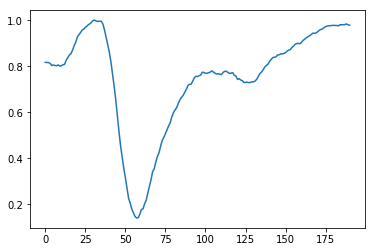

57


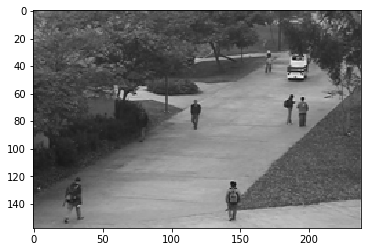

In [39]:
regularity_list = []
with open('testing_regularity_list/40_reg.txt') as f:
    for line in f:
        regularity_list.append(float(line))
import matplotlib.pyplot as plt
plt.plot(regularity_list)
plt.show()

print(regularity_list.index(min(regularity_list)))
plt.imshow(Image.open('test_data/UCSDped1_testing_020/154.tif'))

torch.Size([1, 10, 227, 227])
tensor([[0.3490, 0.3490, 0.3451,  ..., 0.2431, 0.2627, 0.2627],
        [0.3294, 0.3294, 0.3255,  ..., 0.2510, 0.2745, 0.2784],
        [0.3059, 0.3059, 0.3020,  ..., 0.2588, 0.2902, 0.2941],
        ...,
        [0.4784, 0.4784, 0.4784,  ..., 0.7020, 0.7294, 0.7333],
        [0.4824, 0.4824, 0.4824,  ..., 0.7059, 0.7333, 0.7373],
        [0.4824, 0.4824, 0.4824,  ..., 0.7098, 0.7373, 0.7412]])
tensor([[0.4471, 0.4471, 0.4471,  ..., 0.6157, 0.6235, 0.6235],
        [0.4196, 0.4196, 0.4196,  ..., 0.5569, 0.5608, 0.5608],
        [0.3843, 0.3843, 0.3843,  ..., 0.4784, 0.4784, 0.4784],
        ...,
        [0.4667, 0.4667, 0.4745,  ..., 0.6863, 0.6902, 0.6902],
        [0.4549, 0.4549, 0.4588,  ..., 0.6627, 0.6627, 0.6627],
        [0.4431, 0.4431, 0.4431,  ..., 0.6471, 0.6431, 0.6431]])


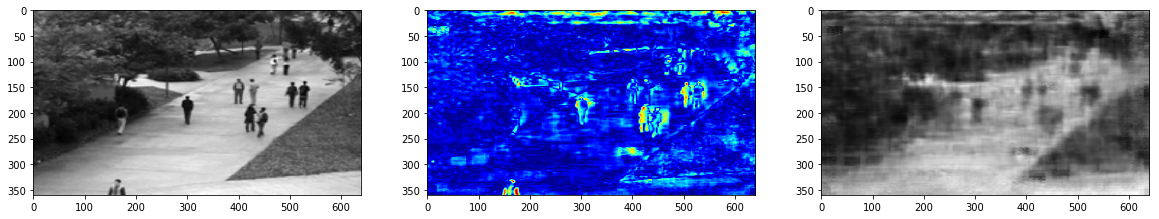

In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CAE().to(device)
model.load_state_dict(torch.load('Avenue_checkpoints/checkpoint-004.pth'))
test_dataset = AvenueTestDataset('test_data/',56)
criteria = nn.MSELoss()

import matplotlib.pyplot as plt

inverse_transform = transforms.Compose([transforms.Normalize((0.0,),(1/0.5,)),
                                        transforms.Normalize((-0.5,),(1,)),
                                        transforms.ToPILImage(),
                                        transforms.Resize((360,640)),transforms.ToTensor()])
fig = plt.figure(figsize=(20,10));
with torch.no_grad():
    x = test_dataset[0]
    x = x.to(device)
    x = x.unsqueeze_(0)
    x_reconst = model(x)
diff = x.squeeze(0)[0]-x_reconst.squeeze(0)[0]
diff = torch.abs(diff)
diff = (diff-torch.min(diff))/torch.max(diff)
x = x.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x = inverse_transform(x)
x = x.squeeze(0)
diff = diff.unsqueeze(0).to(torch.device('cpu'))
diff = inverse_transform(diff)
diff = diff.squeeze(0)
fig.add_subplot(1,3,1)
plt.imshow(x,cmap='gray')
fig.add_subplot(1,3,2)
plt.imshow(diff, cmap='jet')
fig.add_subplot(1,3,3)
print(x_reconst.size())
x_reconst = x_reconst.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x_reconst = inverse_transform(x_reconst)
x_reconst = x_reconst.squeeze(0)
plt.imshow(x_reconst, cmap='gray')

print(x)
print(x_reconst)

In [58]:
model.load_state_dict(torch.load('Avenue_checkpoints/checkpoint-005.pth'))
for param in model.parameters():
    print(param.data)

EOFError: Ran out of input

In [20]:
transform = transforms.Compose([
                                        transforms.Grayscale(),
                                        transforms.Resize([227,227]),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5,),(0.5,))
                                        ])
tensor1=  transform(Image.open('data/Avenue_training_1/image-00001.jpg'))
print(torch.min(tensor1), torch.max(tensor1))
tensor2= transform(Image.open('data/UCSDped1_training_001/001.tif'))
print(torch.min(tensor2), torch.max(tensor2))


tensor(-0.9294) tensor(0.9765)
tensor(-0.9608) tensor(0.7569)


## Performance Measure (Correct Detection/False Alarm, AUC/EER)

In [43]:
#Combining all regularity lists of test videos
regularity_list = []
for i in range(0,69):
    if i<=56:#(i>=21) and (i<=56):
        continue;
    with open('testing_regularity_list/%d_reg.txt'%i) as f:
        for line in f:
            regularity_list.append(float(line))
print(len(regularity_list))
print(15324-9*21)

1902
15135


In [45]:
import os
from scipy import misc
path = 'your_file_path'
for i in range(1,13):
    for j in range(len(os.listdir('../UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test%03d_gt/'%i))):
        image= misc.imread('../UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test001_gt/%03d.bmp'%(j+1), flatten= 0)
        print(image.max()==1)

/home/visitor/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [46]:
##Combining all label lists of test videos
import scipy.io
import numpy as np
import os
from scipy import misc
label_list = []
n = 0
#for i in range(1,22):
#    mat = scipy.io.loadmat('testing_label_mask/%d_label.mat'%i)
#    label = mat.get('volLabel')
#    for j in range(len(label[0])-9):
#        if label[0][j].sum(axis=0).sum(axis=0) > 0:
#            label_list.append(1)
#        else:
#            label_list.append(0)
for i in range(1,13):
    path = '../UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test%03d_gt/'%i
    for j in range(len(os.listdir(path))-9):
        image_list = os.listdir(path)
        image_list.sort()
        image= misc.imread(os.path.join(path, image_list[j]), flatten= 0)
        if(image.max()==0):
            label_list.append(0)
        else:
            label_list.append(1)

len(label_list)

/home/visitor/anaconda3/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


1902

In [47]:
def get_anomaly_list(regularity_list, threshold):
    l = [i for i in range(len(regularity_list)) if regularity_list[i] < threshold]
    if(l==[]):
        return []
    num_detection = 0
    prev_start = l[0]
    detected = []
    for i in range(len(l)-1):
        if (l[i+1]-l[i]>50):
            detected.append((prev_start, l[i]))
            prev_start = l[i+1]
    detected.append((prev_start, l[len(l)-1]))
    return detected


In [48]:
def get_correct_list(anomaly_list, label_list):
    correct_list = []
    num_labels = 0
    for anomaly in anomaly_list:
        for i in range(anomaly[0], anomaly[1]+1):
            if label_list[i]:
                num_labels = num_labels + 1
        if num_labels / (anomaly[1]-anomaly[0]+1) > 0.5:
            correct_list.append(True)
        else:
            correct_list.append(False)
    return correct_list

In [56]:
def get_positive_rate(regularity_list, label_list, threshold):
    anomaly_list = get_anomaly_list(regularity_list, threshold)
    p = sum([e-s+1 for s,e in anomaly_list])
    tp_fn = label_list.count(1)
    tp = 0
    for anomaly in anomaly_list:
        for i in range(anomaly[0], anomaly[1]+1):
            if label_list[i]:
                tp = tp+1
    fp_tn = len(regularity_list)-tp_fn
    fp = p - tp

    
    tpr = tp / tp_fn
    fpr =fp / fp_tn
    return tpr, fpr

In [50]:
anomaly_list = get_anomaly_list(regularity_list, 0.8)
correct_list = get_correct_list(anomaly_list, label_list)
correct_detection = correct_list.count(True)
false_alarm = correct_list.count(False)
print('Correct Detection: ', correct_detection)
print('False Alarm: ', false_alarm)

Correct Detection:  10
False Alarm:  0


In [51]:
x = []
y = []
for i in range(100):
    tp, fp = get_positive_rate(regularity_list, label_list, 0.01*i)
    x.append(fp)
    y.append(tp)
eer_x = [0,1]
eer_y = [1,0]


AUC: 0.8259734879867439
EER: 0.3205882352941177


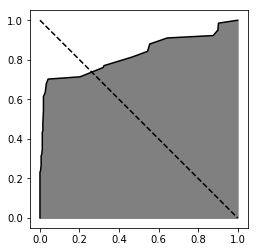

In [52]:
import matplotlib.pyplot as plt
from sklearn import metrics


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(x, y, color='black')
ax.plot(x, [1-i for i in x], '--',color='black')
ax.set_aspect(1)
ax.fill_between(x,y, color='gray')
print('AUC:', metrics.auc(x,y))
fpr = x
tpr = y
fnr = [1-i for i in tpr]
eer = fpr[np.nanargmin(np.absolute((np.subtract(fnr, fpr))))]
print('EER:', eer)

## Spatial Localization of Regularity

torch.Size([1, 10, 227, 227])


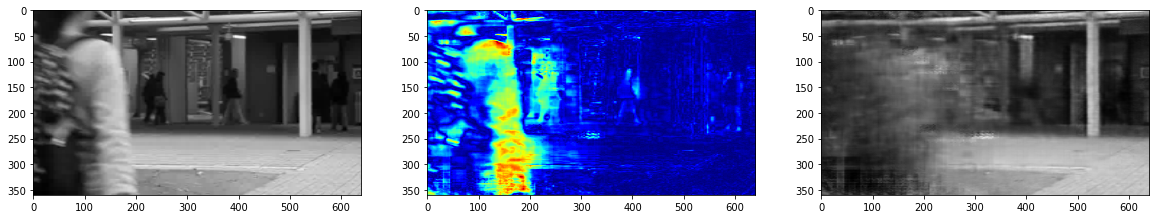

In [66]:
import matplotlib.pyplot as plt

inverse_transform = transforms.Compose([transforms.Normalize((0.0,),(1/0.5,)),
                                        transforms.Normalize((-0.5,),(1,)),
                                        transforms.ToPILImage(),
                                        transforms.Resize((360,640)),transforms.ToTensor()])
fig = plt.figure(figsize=(20,10));
model.load_state_dict(torch.load('Avenue_checkpoints/checkpoint-004.pth'))

test_dataset = AvenueTestDataset('test_data/',0)
with torch.no_grad():
    x = test_dataset[944]
    x = x.to(device)
    x = x.unsqueeze_(0)
    x_reconst = model(x)
diff = x.squeeze(0)[0]-x_reconst.squeeze(0)[0]
diff = torch.abs(diff)
diff = (diff-torch.min(diff))/torch.max(diff)
x = x.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x = inverse_transform(x)
x = x.squeeze(0)
diff = diff.unsqueeze(0).to(torch.device('cpu'))
diff = inverse_transform(diff)
diff = diff.squeeze(0)
fig.add_subplot(1,3,1)
plt.imshow(x,cmap='gray')
fig.add_subplot(1,3,2)
plt.imshow(diff, cmap='jet')
fig.add_subplot(1,3,3)
print(x_reconst.size())
x_reconst = x_reconst.squeeze(0)[0].unsqueeze(0).to(torch.device('cpu'))
x_reconst = inverse_transform(x_reconst)
x_reconst = x_reconst.squeeze(0)
plt.imshow(x_reconst, cmap='gray')
